# week 09 PyTorch practice, hints and Dataloaders

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will teach you to use pytorch low-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [2]:
! pip install pandas

     |████████████████████████████████| 9.7 MB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 10.1 MB/s eta 0:00:01


In [3]:
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

In [ ]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = None  # YOUR CODE HERE

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = None  # YOUR CODE HERE
y = None  # YOUR CODE HERE


plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color="red")
plt.grid()

### Task 2: Using the Dataloader

In [4]:
from torch import nn
from torch.nn import functional as F

In [5]:
!wget https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day10_Optimization_and_regularization_in_DL/notmnist.py

--2021-05-15 15:10:16--  https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day10_Optimization_and_regularization_in_DL/notmnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1799 (1,8K) [text/plain]
Saving to: ‘notmnist.py’

notmnist.py         100%[===================>]   1,76K  --.-KB/s    in 0s      

2021-05-15 15:10:16 (18,1 MB/s) - ‘notmnist.py’ saved [1799/1799]



In [7]:
! pip install sklearn

  Using cached sklearn-0.0-py2.py3-none-any.whl
     |████████████████████████████████| 24.9 MB 12.2 MB/s eta 0:00:01
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
     |████████████████████████████████| 27.2 MB 12.3 MB/s eta 0:00:01


In [8]:
from notmnist import load_notmnist


X_train, y_train, X_test, y_test = load_notmnist()

Extracting ...
Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [11]:
print(Dataset.__doc__)

An abstract class representing a :class:`Dataset`.

    All datasets that represent a map from keys to data samples should subclass
    it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
    data sample for a given key. Subclasses could also optionally overwrite
    :meth:`__len__`, which is expected to return the size of the dataset by many
    :class:`~torch.utils.data.Sampler` implementations and the default options
    of :class:`~torch.utils.data.DataLoader`.

    .. note::
      :class:`~torch.utils.data.DataLoader` by default constructs a index
      sampler that yields integral indices.  To make it work with a map-style
      dataset with non-integral indices/keys, a custom sampler must be provided.
    


In [15]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [12]:
class DatasetMNIST(Dataset):
    def __init__(self, path="./notMNIST_small", letters="ABCDEFGHIJ", transform=None):
        self.data, self.labels, _, _ = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [13]:
full_dataset = DatasetMNIST("./notMNIST_small", "AB", transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [14]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [18]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

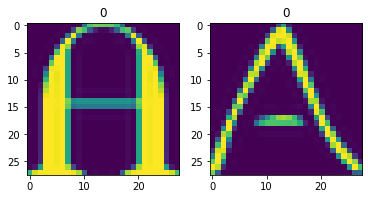

In [27]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28, 28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

In [31]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True, num_workers=1)

We can use dataloader as iterator by using iter() function.

In [32]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [33]:
images, labels = train_iter.next()

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/opt/miniconda3/envs/ml-mipt/lib/python3.8/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


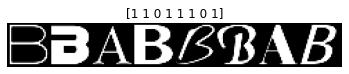

In [34]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.title(labels.numpy());

And now with transformations:

In [35]:
train_dataset_with_transform = DatasetMNIST(transform=torchvision.transforms.ToTensor())

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [36]:
img, lab = train_dataset_with_transform.__getitem__(0)

print("image shape at the first row : {}".format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [37]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = train_iter_tr.next()

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


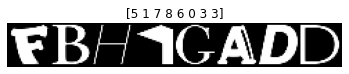

In [38]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [39]:
class Flatten:
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + "()"

In [40]:
a = Flatten()

In [41]:
a(img).shape

torch.Size([784])

In [42]:
new_transform = torchvision.transforms.Compose([
#     torchvision.transforms.CenterCrop(),
#     torchvision.transforms.Resize((640, 460)),
    torchvision.transforms.ToTensor(),
    Flatten(),
])

# Putting all together

In [43]:
import time

from IPython.display import clear_output

In [44]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [45]:
def subset_ind(dataset, ratio: float):
    #     return ### YOUR CODE HERE
    return np.random.choice(len(dataset), size=int(ratio * len(dataset)), replace=False)

In [77]:
dataset = DatasetMNIST(
    "./notMNIST_small",
#     'AB',
    transform=new_transform,
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f"\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}")

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [78]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f"  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}")

  training size: 2996
validation size: 748


In [79]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [80]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [81]:
loss_func = nn.CrossEntropyLoss()

In [99]:
default_dtype = torch.float32

In [83]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid(),
)
model.to(device, default_dtype)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [85]:
preds = torch.rand(3, 10)
preds

tensor([[0.4806, 0.6802, 0.0381, 0.5422, 0.6567, 0.5430, 0.6537, 0.5226, 0.2279,
         0.3902],
        [0.6211, 0.8917, 0.3093, 0.0495, 0.6781, 0.8197, 0.1211, 0.9736, 0.0322,
         0.8309],
        [0.8251, 0.5027, 0.8808, 0.2980, 0.7043, 0.5328, 0.9818, 0.3102, 0.4730,
         0.5518]])

In [93]:
vals, inds = preds.max(-1)

In [94]:
inds

tensor([1, 7, 6])

In [95]:
vals

tensor([0.6802, 0.9736, 0.9818])

In [102]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    """
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    """
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)  # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            ### YOUR CODE HERE
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            
            opt.zero_grad()
            loss.backward()

            opt.step()
            
            ep_train_loss.append(loss.item())

        model.train(False)  # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                # YOUR CODE HERE
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)

                # compute predictions
                # YOUR CODE HERE
                ep_val_loss.append(loss.item())  # YOUR CODE HERE
                y_pred = preds.max(-1)[1]  # YOUR CODE HERE
                ep_val_accuracy.append((y_pred == y_batch).to(default_dtype).mean().item())  # YOUR CODE HERE

        # print the results for this epoch:
        print(f"Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s")

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [103]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 0.119s
	  training loss: 1.659519
	validation loss: 1.665598
	validation accuracy: 0.869
Epoch 2 of 30 took 0.095s
	  training loss: 1.641251
	validation loss: 1.653516
	validation accuracy: 0.865
Epoch 3 of 30 took 0.098s
	  training loss: 1.628397
	validation loss: 1.649227
	validation accuracy: 0.866
Epoch 4 of 30 took 0.100s
	  training loss: 1.619867
	validation loss: 1.640783
	validation accuracy: 0.862
Epoch 5 of 30 took 0.097s
	  training loss: 1.612831
	validation loss: 1.637113
	validation accuracy: 0.863
Epoch 6 of 30 took 0.096s
	  training loss: 1.607206
	validation loss: 1.637276
	validation accuracy: 0.864
Epoch 7 of 30 took 0.096s
	  training loss: 1.602310
	validation loss: 1.635178
	validation accuracy: 0.866
Epoch 8 of 30 took 0.095s
	  training loss: 1.598340
	validation loss: 1.633295
	validation accuracy: 0.860
Epoch 9 of 30 took 0.098s
	  training loss: 1.594432
	validation loss: 1.628669
	validation accuracy: 0.869
Epoch 10 of 30 took 0.096s
	

In [104]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title("Loss")
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()

    axes[1].set_title("Validation accuracy")
    axes[1].plot(val_accuracy)

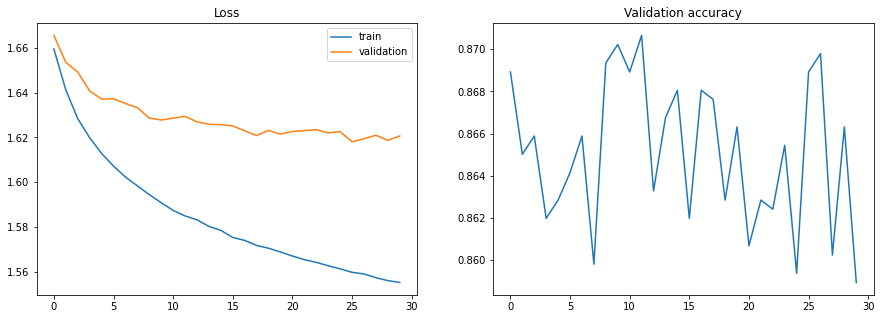

In [105]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [106]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [107]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 0.156s
	  training loss: 1.707134
	validation loss: 1.609330
	validation accuracy: 0.745
Epoch 2 of 30 took 0.145s
	  training loss: 1.587000
	validation loss: 1.590280
	validation accuracy: 0.834
Epoch 3 of 30 took 0.146s
	  training loss: 1.552098
	validation loss: 1.567466
	validation accuracy: 0.890
Epoch 4 of 30 took 0.148s
	  training loss: 1.533718
	validation loss: 1.564371
	validation accuracy: 0.891
Epoch 5 of 30 took 0.147s
	  training loss: 1.524915
	validation loss: 1.564182
	validation accuracy: 0.880
Epoch 6 of 30 took 0.146s
	  training loss: 1.518591
	validation loss: 1.560097
	validation accuracy: 0.892
Epoch 7 of 30 took 0.147s
	  training loss: 1.512614
	validation loss: 1.576296
	validation accuracy: 0.877
Epoch 8 of 30 took 0.148s
	  training loss: 1.509178
	validation loss: 1.558644
	validation accuracy: 0.892
Epoch 9 of 30 took 0.147s
	  training loss: 1.510325
	validation loss: 1.560573
	validation accuracy: 0.894
Epoch 10 of 30 took 0.149s
	

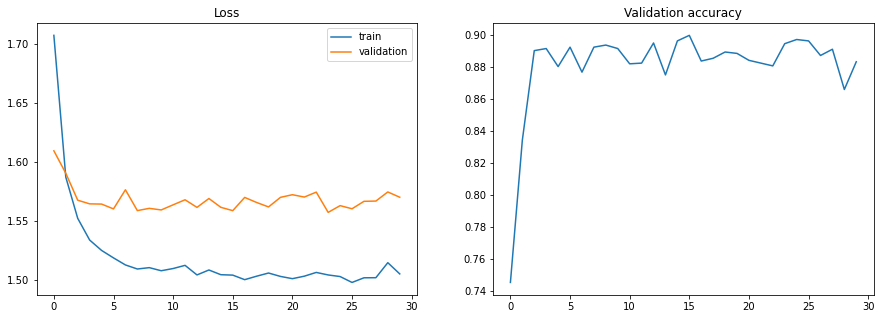

In [108]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [109]:
import torchsummary

In [111]:
28**2

784

In [115]:
torchsummary.summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
              ReLU-2                  [-1, 500]               0
            Linear-3                  [-1, 200]         100,200
              ReLU-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
           Sigmoid-6                   [-1, 10]               0
Total params: 494,710
Trainable params: 494,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.89
Estimated Total Size (MB): 1.90
----------------------------------------------------------------


## Overfit!!!

In [201]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 600),
    nn.ReLU(),
    nn.Linear(600, 500),
    nn.ReLU(),
    nn.Linear(500, 400),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [202]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 0.494s
	  training loss: 2.134934
	validation loss: 2.014964
	validation accuracy: 0.178
Epoch 2 of 30 took 0.499s
	  training loss: 2.045046
	validation loss: 2.026333
	validation accuracy: 0.172
Epoch 3 of 30 took 0.491s
	  training loss: 2.016687
	validation loss: 1.994847
	validation accuracy: 0.189
Epoch 4 of 30 took 0.460s
	  training loss: 1.986748
	validation loss: 1.983032
	validation accuracy: 0.219
Epoch 5 of 30 took 0.463s
	  training loss: 2.081405
	validation loss: 2.143732
	validation accuracy: 0.175
Epoch 6 of 30 took 0.457s
	  training loss: 2.112326
	validation loss: 2.127975
	validation accuracy: 0.190
Epoch 7 of 30 took 0.502s
	  training loss: 2.108410
	validation loss: 2.114670
	validation accuracy: 0.188
Epoch 8 of 30 took 0.487s
	  training loss: 2.019658
	validation loss: 1.881535
	validation accuracy: 0.300
Epoch 9 of 30 took 0.514s
	  training loss: 1.957081
	validation loss: 1.979256
	validation accuracy: 0.238
Epoch 10 of 30 took 0.539s
	

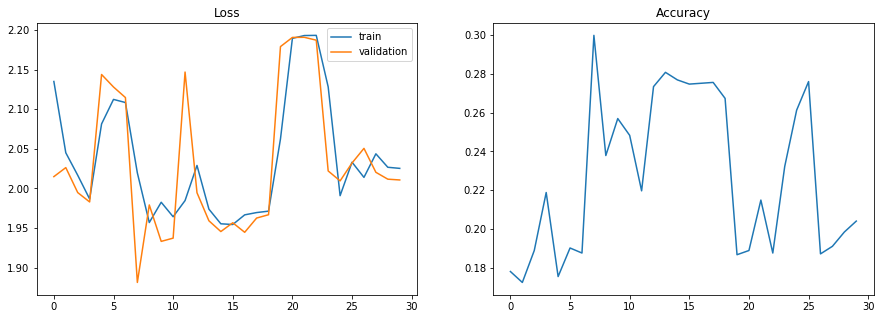

In [203]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

### Dropout try

### Batchnorm try

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print("model saved to %s" % checkpoint_path)


def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    print("model loaded from %s" % checkpoint_path)

In [ ]:
# create a brand new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Testing -- you should get a pretty poor performance since the model hasn't learned anything yet.
test()

#### Define a training loop with model checkpointing

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        ep,
                        batch_idx * len(data),
                        len(trainset_loader.dataset),
                        100.0 * batch_idx / len(trainset_loader),
                        loss.item(),
                    )
                )
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint("mnist-%i.pth" % iteration, model, optimizer)
            iteration += 1
        test()

    # save the final model
    save_checkpoint("mnist-%i.pth" % iteration, model, optimizer)

In [ ]:
train_save(5, save_interval=500, log_interval=100)

In [ ]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint("mnist-4690.pth", model, optimizer)
# should give you the final model accuracy
test()

```

```

```

```

```

```

```

```

```

```
### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)